In [ ]:
import getpass
import os
import ast
import pandas as pd
from langchain.chat_models import init_chat_model
from langchain_openai import OpenAIEmbeddings
from langchain_core.vectorstores import InMemoryVectorStore
os.chdir("/Users/jingyi/Research/FYP/LLM/conjoint_openai/Belif-Elicitation-on-LLM-postrelease/RAG_langchain/")
# os.environ["LANGSMITH_TRACING"] = "true"
# os.environ["LANGSMITH_API_KEY"] = getpass.getpass()
# if not os.environ.get("OPENAI_API_KEY"):
#   os.environ["OPENAI_API_KEY"] = getpass.getpass("Enter API key for OpenAI: ")

llm = init_chat_model("gpt-5-nano", temperature = 1, reasoning_effort = 'medium', model_provider="openai")
embeddings = OpenAIEmbeddings(model="text-embedding-3-large")
vector_store = InMemoryVectorStore(embeddings)

# Load data

In [2]:
# pip install langchain-community beautifulsoup4 chardet  # 如未安装，请先安装

from pathlib import Path
from typing import Optional, List
from bs4 import BeautifulSoup, SoupStrainer
from langchain_community.document_loaders import TextLoader
from langchain_core.documents import Document


def extract_title_and_content(
    html: str,
    title_selectors: Optional[List[str]] = None,
    content_selectors: Optional[List[str]] = None,
) -> str:
    """
    从完整 HTML 中只提取标题与正文，并尽量过滤掉导航、页脚、侧栏、脚注、脚本样式等噪音。
    如果未传入 selectors, 会使用一组常见的兜底选择器。
    """

    # 只解析 <body> 以降低解析量（可选）
    body_only = SoupStrainer(name=lambda tag: tag == "body" or tag is None)
    soup = BeautifulSoup(html, "html.parser", parse_only=body_only)

    # 先移除明显的无关节点（广告、导航、脚注、脚本样式等）
    for selector in [
        "script",
        "style",
        "noscript",
        "template",
        "svg",
        "header",
        "nav",
        "aside",
        "footer",
        "[role=banner]",
        "[role=navigation]",
        "[role=complementary]",
        "[role=contentinfo]",
        ".sidebar",
        ".site-nav",
        ".navbar",
        ".breadcrumbs",
        ".pagination",
        ".ad, .ads, .advert, .advertisement",
        ".cookie, .cookie-banner, .cookie-consent",
        ".comments, .comment, #comments",
    ]:
        for node in soup.select(selector):
            node.decompose()

    # 寻找标题
    if not title_selectors:
        title_selectors = [
            ".post-title",
            "h1.post-title",
            "article h1",
            "main h1",
            "h1",
            "header h1",
            "title",  # HTML <title> 兜底
        ]

    title_text = ""
    for sel in title_selectors:
        node = soup.select_one(sel)
        if node and node.get_text(strip=True):
            title_text = node.get_text(separator=" ", strip=True)
            break

    # 寻找正文主区
    if not content_selectors:
        content_selectors = [
            ".post-content",
            "article .content",
            "article",
            "main .content",
            "main article",
            "main",
            "#content",
            ".content",
        ]

    main_section = None
    for sel in content_selectors:
        main_section = soup.select_one(sel)
        if main_section:
            break
    if not main_section:
        # 最兜底：直接用 <body>
        main_section = soup.body or soup

    # 再次清理正文候选里的明显无关块
    for selector in [
        ".toc, #toc, .table-of-contents",
        "footer",
        ".share, .social, .social-share",
        ".related, .related-posts",
    ]:
        for node in main_section.select(selector):
            node.decompose()

    content_text = main_section.get_text(separator="\n", strip=True)

    # 组装输出文本：标题 + 空行 + 正文
    combined = title_text.strip()
    if combined and content_text:
        combined += "\n\n" + content_text
    elif not combined:
        combined = content_text

    return combined


def load_html_then_filter(
    html_path: str,
    title_selectors: Optional[List[str]] = None,
    content_selectors: Optional[List[str]] = None,
) -> List[Document]:
    """
    通过 LangChain TextLoader 读取本地 HTML,
    然后用 BeautifulSoup 精筛出标题与正文，最终返回一个或多个 Document.
    """
    path = Path(html_path)
    if not path.exists():
        raise FileNotFoundError(f"HTML file not found: {html_path}")

    # 1) 使用 LangChain 的 TextLoader 读取原始 HTML（autodetect_encoding 尝试自动识别编码）
    loader = TextLoader(str(path), autodetect_encoding=True)
    raw_docs = loader.load()
    if len(raw_docs) == 0:
        raise ValueError("No document loaded. Check the file path or encoding.")

    raw_html = raw_docs[0].page_content  # 原始 HTML 字符串
    source_meta = raw_docs[0].metadata

    # 2) 用 BS 精筛想要的部分
    clean_text = extract_title_and_content(
        raw_html,
        title_selectors=title_selectors,
        content_selectors=content_selectors,
    )

    # 3) 封装为 LangChain Document
    doc = Document(
        page_content=clean_text,
        metadata={
            **source_meta,
            "source": str(path),
            "extracted": True,
            "note": "title + main content only",
        },
    )
    return [doc]

In [3]:
from pathlib import Path
from typing import List, Optional
import os

# ✅ Correct imports for LangChain v0.2+
from langchain_core.documents import Document
from langchain_community.document_loaders import PyPDFLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter

from bs4 import BeautifulSoup


# ========== Your CSS selectors ==========
TITLE_SELECTORS = [
    ".post-title",
    "h1.post-title",
    "article h1",
    "main h1",
    "h1",
    "title",
]
CONTENT_SELECTORS = [
    ".post-content",
    "article .content",
    "article",
    "main .content",
    "main article",
    "main",
    "#content",
    ".content",
]


# ========== Utility functions ==========

def _read_text(path: Path) -> str:
    """Safely read text from a file with UTF-8, ignoring bad characters if needed."""
    try:
        return path.read_text(encoding="utf-8")
    except UnicodeDecodeError:
        return path.read_text(encoding="utf-8", errors="ignore")


def _pick_first(soup: BeautifulSoup, selectors: List[str]) -> Optional[str]:
    """Return text from the first matching selector."""
    for css in selectors:
        node = soup.select_one(css)
        if node:
            text = node.get_text(" ", strip=True)
            if text:
                return text
    return None


def _pick_all_join(soup: BeautifulSoup, selectors: List[str]) -> Optional[str]:
    """Return concatenated text from the first selector that matches any nodes."""
    for css in selectors:
        nodes = soup.select(css)
        if nodes:
            parts = []
            for n in nodes:
                txt = n.get_text("\n", strip=True)
                if txt:
                    parts.append(txt)
            joined = "\n\n".join(p for p in parts if p.strip())
            if joined.strip():
                return joined
    return None


def extract_html_with_selectors(
    file_path: Path,
    title_selectors: List[str],
    content_selectors: List[str],
) -> Optional[Document]:
    """Extract title and main content from one HTML file using CSS selectors."""
    raw = _read_text(file_path)
    soup = BeautifulSoup(raw, "lxml")

    # Try to extract title; fallback to <title> or filename
    title = _pick_first(soup, title_selectors)
    if not title:
        if soup.title and soup.title.string:
            title = soup.title.string.strip()
        else:
            title = file_path.stem

    # Try to extract main content; fallback to all visible text
    content = _pick_all_join(soup, content_selectors)
    if not content:
        content = soup.get_text("\n", strip=True)

    content = content.strip()
    if not content:
        return None

    meta = {
        "source": str(file_path),
        "filename": file_path.name,
        "title": title,
        "type": "html",
    }
    return Document(page_content=content, metadata=meta)


def load_pdf_as_docs(file_path: Path) -> List[Document]:
    """Load one PDF as a list of page-level Documents."""
    loader = PyPDFLoader(str(file_path))
    docs = loader.load()
    for d in docs:
        d.metadata = {
            **d.metadata,
            "source": str(file_path),
            "filename": file_path.name,
            "title": file_path.stem,
            "type": "pdf",
        }
    return docs


def load_folder_pdfs_individual(pdf_path: Path) -> List[Document]:
    """Helper function: process one PDF file."""
    return load_pdf_as_docs(pdf_path)


def load_folder_mixed(
    folder: str,
    title_selectors: List[str],
    content_selectors: List[str],
    recursive: bool = True,
) -> List[Document]:
    """
    Load both HTML and PDF files from a folder (and subfolders if recursive=True),
    returning all as LangChain Documents.
    """
    base = Path(folder)
    pattern = "**/*" if recursive else "*"

    html_docs: List[Document] = []
    pdf_docs: List[Document] = []

    # --- Parse HTML files ---
    for p in base.glob(pattern):
        if p.is_file() and p.suffix.lower() in {".html", ".htm"}:
            doc = extract_html_with_selectors(p, title_selectors, content_selectors)
            if doc:
                html_docs.append(doc)

    # --- Parse PDF files ---
    for p in base.glob(pattern):
        if p.is_file() and p.suffix.lower() == ".pdf":
            pdf_docs.extend(load_folder_pdfs_individual(p))

    return html_docs + pdf_docs


def split_docs(docs: List[Document], chunk_size: int = 800, chunk_overlap: int = 100) -> List[Document]:
    """Optional: split long documents into smaller overlapping chunks."""
    splitter = RecursiveCharacterTextSplitter(chunk_size=chunk_size, chunk_overlap=chunk_overlap)
    return splitter.split_documents(docs)


# ========== Main entry point ==========
docs = load_folder_mixed(
    folder="./raw_material/iPhone16lineup/",
    title_selectors=TITLE_SELECTORS,
    content_selectors=CONTENT_SELECTORS,
    recursive=True,  # set False if you only want the current folder
)

# Example: inspect the first document
if not docs:
    print("No HTML or PDF files were parsed in this folder.")
else:
    print(f"Total documents loaded: {len(docs)}")
    print(f"Type: {docs[0].metadata.get('type')}")
    print(f"Source: {docs[0].metadata.get('source')}")
    print(f"Title: {docs[0].metadata.get('title')}")
    print(f"Character count: {len(docs[0].page_content)}")
    print("\n====== Preview (first 800 chars) ======\n")
    print(docs[0].page_content[:800])


Total documents loaded: 7
Type: html
Source: raw_material/iPhone16lineup/121031.html
Title: iPhone 16 Pro - Tech Specs
Character count: 33635

====== Preview (first 800 chars) ======

iPhone 16 Pro - Tech Specs
Year introduced: 2024
Identify your iPhone model
Finish
Black Titanium
White Titanium
Natural Titanium
Desert Titanium
Titanium design, Latest-generation Ceramic Shield front, Textured matte glass back
Capacity
1
128GB
256GB
512GB
1TB
Size and Weight
2
Width:
2.81 inches (71.5 mm)
Height:
5.89 inches (149.6 mm)
Depth:
0.32 inch (8.25 mm)
Weight:
7.03 ounces (199 grams)
Display
Super Retina XDR display
6.3‑inch (diagonal) all‑screen OLED display
2622‑by‑1206-pixel resolution at 460 ppi
Dynamic Island
Always-On display
ProMotion technology with adaptive refresh rates up to 120Hz
HDR display
True Tone
Wide color (P3)
Haptic Touch
2,000,000:1 contrast ratio (typical)
1000 nits max brightness (typical); 1600 nits peak brightness (HDR); 2000 nits peak brightness (outdo


In [4]:
docs

[Document(metadata={'source': 'raw_material/iPhone16lineup/121031.html', 'filename': '121031.html', 'title': 'iPhone 16 Pro - Tech Specs', 'type': 'html'}, page_content='iPhone 16 Pro - Tech Specs\nYear introduced: 2024\nIdentify your iPhone model\nFinish\nBlack Titanium\nWhite Titanium\nNatural Titanium\nDesert Titanium\nTitanium design, Latest-generation Ceramic Shield front, Textured matte glass back\nCapacity\n1\n128GB\n256GB\n512GB\n1TB\nSize and Weight\n2\nWidth:\n2.81 inches (71.5 mm)\nHeight:\n5.89 inches (149.6 mm)\nDepth:\n0.32 inch (8.25 mm)\nWeight:\n7.03 ounces (199 grams)\nDisplay\nSuper Retina XDR display\n6.3‑inch (diagonal) all‑screen OLED\xa0display\n2622‑by‑1206-pixel resolution at 460\xa0ppi\nDynamic Island\nAlways-On display\nProMotion technology with adaptive refresh rates up to 120Hz\nHDR display\nTrue\xa0Tone\nWide color (P3)\nHaptic Touch\n2,000,000:1 contrast ratio (typical)\n1000 nits max brightness (typical); 1600 nits peak brightness (HDR); 2000\xa0nits pea

# Splitting document

In [5]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000,  # chunk size (characters)
    chunk_overlap=200,  # chunk overlap (characters)
    add_start_index=True,  # track index in original document
)
all_splits = text_splitter.split_documents(docs)

print(f"Split into {len(all_splits)} sub-documents.")

Split into 218 sub-documents.


In [6]:
document_ids = vector_store.add_documents(documents=all_splits)

print(document_ids[:3])

['81b6ffb6-df64-4969-ba11-b7aca141f9e6', '6b99497d-fb5b-45fd-95a3-b4699f572f0a', '0458fdf3-6641-42f1-bdb9-64648c37b050']


# Retrieval and generation

In [7]:
from langchain_classic import hub

prompt = hub.pull("rlm/rag-prompt")

example_messages = prompt.invoke(
    {"context": "(context goes here)", "question": "(question goes here)"}
).to_messages()

assert len(example_messages) == 1
print(example_messages[0].content)

You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.
Question: (question goes here) 
Context: (context goes here) 
Answer:


In [8]:
from langchain_core.documents import Document
from typing_extensions import List, TypedDict


class State(TypedDict):
    question: str
    context: List[Document]
    answer: str

def retrieve(state: State):
    retrieved_docs = vector_store.similarity_search(state["question"])
    return {"context": retrieved_docs}


def generate(state: State):
    docs_content = "\n\n".join(doc.page_content for doc in state["context"])
    messages = prompt.invoke({"question": state["question"], "context": docs_content})
    response = llm.invoke(messages)
    return {"answer": response.content}

from langgraph.graph import START, StateGraph

graph_builder = StateGraph(State).add_sequence([retrieve, generate])
graph_builder.add_edge(START, "retrieve")
graph = graph_builder.compile()

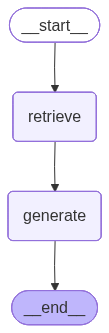

In [9]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [10]:
result = graph.invoke({"question": "What is the next generation of iPhone lineup? And what is its release date?"})

print(f"Context: {result['context']}\n\n")
print(f"Answer: {result['answer']}")

Context: [Document(id='28715e22-7802-44d9-b098-71a05f3874a3', metadata={'source': 'raw_material/iPhone16lineup/macrumor_iPhone17.html', 'filename': 'macrumor_iPhone17.html', 'title': 'iPhone 17', 'type': 'html', 'start_index': 1218}, page_content='all-new iPhone 17 "Air"\nthat has a much thinner design, a new display size, a different look for the camera, and more.\nWe are expecting four total models in 2025: the iPhone 17, the iPhone 17 Pro, the iPhone 17 Pro Max, and the new iPhone 17 "Air." There will be no iPhone 17 Plus, with Apple doing away with the "Plus" lineup because it has not proven popular with customers. The slimmed down iPhone 17 won\'t be a direct replacement for the iPhone 17 Plus, instead making a debut as a new device option in the lineup. Rumors suggest that the upcoming device will have a display that\'s around 6.6 inches, and a chassis that\'s 6mm thick or less.\nIf we compare the iPhone lineup to the Mac and iPad lineups, the iPhone 17 Air will be comparable to 

In [16]:
for step in graph.stream(
    {"question": "Assume today is March 27, 2025. What is the next generation of iPhone lineup?"}, stream_mode="updates"
):
    print(f"{step}\n\n----------------\n")

{'retrieve': {'context': [Document(id='237ddcaa-998d-4053-ad54-30cef090a03a', metadata={'source': 'raw_material/iPhone16lineup/121029.html', 'filename': '121029.html', 'title': 'iPhone 16 - Tech Specs', 'type': 'html', 'start_index': 0}, page_content='iPhone 16 - Tech Specs\nYear introduced: 2024\nIdentify your iPhone model\nFinish\nBlack\nWhite\nPink\nTeal\nUltramarine\nAluminum design, Latest-generation Ceramic Shield\xa0front, Color-infused glass back (Black, Pink, Teal, Ultramarine)\nCapacity\n1\n128GB\n256GB\n512GB\nSize and Weight\n2\nWidth:\n2.82 inches (71.6 mm)\nHeight:\n5.81 inches (147.6 mm)\nDepth:\n0.31 inch (7.80 mm)\nWeight:\n6.00 ounces (170 grams)\nDisplay\nSuper Retina XDR display\n6.1‑inch (diagonal) all‑screen OLED\xa0display\n2556‑by‑1179-pixel resolution at 460\xa0ppi\nDynamic Island\nHDR display\nTrue\xa0Tone\nWide color (P3)\nHaptic Touch\n2,000,000:1 contrast ratio (typical)\n1000 nits max brightness (typical); 1600 nits peak brightness\xa0(HDR); 2000 nits peak

In [ ]:
# for message, metadata in graph.stream(
#     {"question": "What is Task Decomposition?"}, stream_mode="messages"
# ):
#     print(message.content, end="|")

In [ ]:
# from langchain_core.prompts import PromptTemplate

# template = """Use the following pieces of context to answer the question at the end.
# If you don't know the answer, just say that you don't know, don't try to make up an answer.
# Use three sentences maximum and keep the answer as concise as possible.
# Always say "thanks for asking!" at the end of the answer.

# {context}

# Question: {question}

# Helpful Answer:"""
# custom_rag_prompt = PromptTemplate.from_template(template)

# Fit with conjoint questions

In [40]:
df_air = pd.read_csv("../output/iPhone 17 Air_fixreal5000.csv")
# randomly select 500 from df_air
df_air_sample = df_air.sample(n=500, random_state=42)
df_air_sample['rag_prompt_response'] = None
df_air_sample['rag_chosen_id'] = None

In [87]:
# df_air_sample['rag_chosen_id']中有多少个None
df_air_sample['rag_chosen_id'].values[-14]

'44'

In [88]:
for i in df_air_sample.index[-13:]:
    lst = ast.literal_eval(df_air_sample.loc[i,'prompt'])
    rag_prompt = ''.join([j['content'] for j in lst])
    rag_prompt = 'Assume today is March 17, 2025. ' + rag_prompt
    result = graph.invoke({"question": rag_prompt})
    df_air_sample.loc[i,'rag_prompt_response'] = result['answer']
    labels = ['iPhone 17 Air', str(df_air_sample.loc[i,'profile_id'])]
    if result['answer']==df_air_sample.loc[i,'prompt_response']:
        df_air_sample.loc[i,'rag_chosen_id'] = df_air_sample.loc[i,'chosen_id']
    else:
        df_air_sample.loc[i,'rag_chosen_id'] = [x for x in labels if x != df_air_sample.loc[i,'chosen_id']][0]

In [89]:
df_air_sample.to_csv("../output/rag_langchain_iPhone 17 Air_fixreal500.csv")

In [90]:
df_air_sample

,model,temperature,profile_id,pair,prompt_variant,prompt,prompt_response,chosen_profile,chosen_id,rag_prompt_response,rag_chosen_id
1501,gpt-5-nano,1,877,{'R': {'battery life': '18 hours video playbac...,1,"[{'role': 'system', 'content': ""You will be sh...",R,"{'battery life': '18 hours video playback', 's...",877,O,iPhone 17 Air
2586,gpt-5-nano,1,2001,{'U': {'battery life': '27 hours video playbac...,6,"[{'role': 'system', 'content': ""Two smartphone...",U,"{'battery life': '27 hours video playback', 's...",iPhone 17 Air,U,iPhone 17 Air
2653,gpt-5-nano,1,2070,{'U': {'battery life': '30 hours video playbac...,3,"[{'role': 'system', 'content': ""You will recei...",P,"{'battery life': '27 hours video playback', 's...",iPhone 17 Air,P,iPhone 17 Air
1055,gpt-5-nano,1,411,{'W': {'battery life': '24 hours video playbac...,5,"[{'role': 'system', 'content': 'Participants a...",V,"{'battery life': '27 hours video playback', 's...",iPhone 17 Air,V,iPhone 17 Air
705,gpt-5-nano,1,48,{'L': {'battery life': '41 hours video playbac...,5,"[{'role': 'system', 'content': 'Participants a...",V,"{'battery life': '27 hours video playback', 's...",iPhone 17 Air,V,iPhone 17 Air
...,...,...,...,...,...,...,...,...,...,...,...
3928,gpt-5-nano,1,3387,{'O': {'battery life': '27 hours video playbac...,8,"[{'role': 'system', 'content': ""This task pres...",L,"{'battery life': '24 hours video playback', 's...",3387,O,iPhone 17 Air
544,gpt-5-nano,1,5735,{'R': {'battery life': '27 hours video playbac...,6,"[{'role': 'system', 'content': ""Two smartphone...",V,"{'battery life': '31 hours video playback', 's...",5735,R,iPhone 17 Air
367,gpt-5-nano,1,6920,{'G': {'battery life': '31 hours video playbac...,9,"[{'role': 'system', 'content': 'Two smartphone...",G,"{'battery life': '31 hours video playback', 's...",6920,G,6920
1612,gpt-5-nano,1,990,{'O': {'battery life': '27 hours video playbac...,2,"[{'role': 'system', 'content': 'Two smartphone...",O,"{'battery life': '27 hours video playback', 's...",iPhone 17 Air,O,iPhone 17 Air
